In [653]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [654]:
image_path = '/content/carmelozios.png'

In [655]:
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [656]:
def preprocessing(image_bgr, mean_thresh=127, to_binary=False):
    # Converti in scala di grigi
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Normalizza tra 0 e 255
    gray_norm = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Calcola la media d’intensità
    mean_intensity = np.mean(gray_norm)

    # Inversione se sfondo chiaro
    if mean_intensity > mean_thresh:
        gray_norm = cv2.bitwise_not(gray_norm)

    if to_binary:
        _, binary = cv2.threshold(gray_norm, 155, 255, cv2.THRESH_BINARY)
        return binary

    return gray_norm

In [657]:
def segment_and_analyze(binary_img, orig_img=None, min_area=0, merge_threshold=0.5, vertical_gap_ratio=1.5):

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)

    if orig_img is None:
        draw_img = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    else:
        draw_img = orig_img.copy()

    bboxes = []
    for label in range(1, num_labels):
        x, y, w, h, area = stats[label]
        if area >= min_area:
            bboxes.append((x, y, w, h))

    bboxes.sort(key=lambda box: box[0])

    merged = [False] * len(bboxes)
    new_bboxes = []

    for i in range(len(bboxes)):
        if merged[i]:
            continue
        x1, y1, w1, h1 = bboxes[i]
        merged_box = [x1, y1, x1 + w1, y1 + h1]

        for j in range(i + 1, len(bboxes)):
            if merged[j]:
                continue
            x2, y2, w2, h2 = bboxes[j]
            x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
            min_width = min(w1, w2)
            overlap_ratio = x_overlap / min_width if min_width > 0 else 0
            vertical_distance = abs(y2 - (y1 + h1)) if y2 > y1 else abs(y1 - (y2 + h2))
            max_height = max(h1, h2)

            if overlap_ratio >= merge_threshold and vertical_distance <= vertical_gap_ratio * max_height:
                merged_box[0] = min(merged_box[0], x2)
                merged_box[1] = min(merged_box[1], y2)
                merged_box[2] = max(merged_box[2], x2 + w2)
                merged_box[3] = max(merged_box[3], y2 + h2)
                merged[j] = True

        final_box = (
            merged_box[0],
            merged_box[1],
            merged_box[2] - merged_box[0],
            merged_box[3] - merged_box[1]
        )
        new_bboxes.append(final_box)
        cv2.rectangle(draw_img, (final_box[0], final_box[1]), (final_box[0] + final_box[2], final_box[1] + final_box[3]), (0, 255, 0), 1)

    # Bounding box generale della parola
    x_min = min(x for x, y, w, h in new_bboxes)
    y_min = min(y for x, y, w, h in new_bboxes)
    x_max = max(x + w for x, y, w, h in new_bboxes)
    y_max = max(y + h for x, y, w, h in new_bboxes)
    word_bbox = (x_min, y_min, x_max - x_min, y_max - y_min)

    word_height = y_max - y_min

    # Disegna la bounding box della parola
    cv2.rectangle(draw_img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 1)

    # Calcola le distanze in percentuale top e bottom, orizzontale in pixel
    distanze_verticali_top_pct = []
    distanze_verticali_bottom_pct = []
    distanze_orizzontali = []

    for i, (x, y, w, h) in enumerate(new_bboxes):
        dist_top_pct = 100 * (y - y_min) / word_height if word_height > 0 else 0
        dist_bottom_pct = 100 * (y_max - (y + h)) / word_height if word_height > 0 else 0
        distanze_verticali_top_pct.append(dist_top_pct)
        distanze_verticali_bottom_pct.append(dist_bottom_pct)

        if i < len(new_bboxes) - 1:
            x2, _, _, _ = new_bboxes[i + 1]
            distanza_dx = x2 - (x + w)
            distanze_orizzontali.append(distanza_dx)
        else:
            distanze_orizzontali.append(None)

    return new_bboxes, draw_img, word_bbox, distanze_verticali_top_pct, distanze_verticali_bottom_pct, distanze_orizzontali

In [658]:
def extract_letters(gray_image, bboxes):
    letter_imgs = []
    for x, y, w, h in bboxes:

        cropped = gray_image[y:y+h, x:x+w]  # immagine in scala di grigi

        # Resize proporzionale
        if w > h:
            scale = 28 / w
            new_w = 28
            new_h = int(h * scale)
        else:
            scale = 28 / h
            new_h = 28
            new_w = int(w * scale)

        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Canvas nero (1 canale)
        canvas = np.zeros((28, 28), dtype=np.uint8)

        # Centra la lettera
        x_offset = (28 - new_w) // 2
        y_offset = (28 - new_h) // 2
        canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

        letter_imgs.append(canvas)
    return letter_imgs

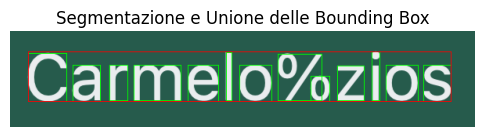

Distanza top (in %): 26.984126984126984
Distanza bottom (in %): 0.0
Distanza orizzontale (in pixel) alla lettera successiva: 12


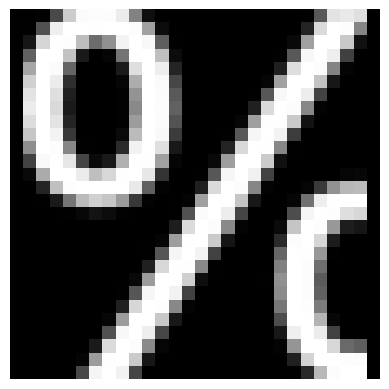

In [659]:
binary = preprocessing(image_rgb, mean_thresh=127, to_binary=True)
bboxes, img_out, bbox_parola, dist_top, dist_bottom, dist_orizz = segment_and_analyze(binary, image_rgb)

plt.figure(figsize=(6, 6))
plt.imshow(img_out)
plt.title('Segmentazione e Unione delle Bounding Box')
plt.axis('off')
plt.show()

gray_image = preprocessing(image_rgb, mean_thresh=127, to_binary=False)
letters_28x28 = extract_letters(gray_image, bboxes)
plt.imshow(letters_28x28[7], cmap='gray')
print(f"Distanza top (in %): {dist_top[1]}")
print(f"Distanza bottom (in %): {dist_bottom[1]}")
print(f"Distanza orizzontale (in pixel) alla lettera successiva: {dist_orizz[1]}")
plt.axis('off')
plt.show()